# Best Practices in Coefficient Stability
Julian Hsu
1 March 2023

The purpose of this script is to demonstrate the idea of Coefficient Stability following [Oster 2013](https://www.nber.org/system/files/working_papers/w19054/w19054.pdf) which is in the same spirit as [Imbens 2003](https://www.aeaweb.org/articles?id=10.1257/000282803321946921).

At a high level, this coefficient stability metric answers the question of how much bias would unobserved variables potential control for so that it could increase $R^2$ a certain level and change the treatment estimate by a certain level. In other words, given what we can predict and estimate with what we can observe, how dramatic must the omitted variable be? This requires user input of how much it could matter.

*Oster 2013* combines the omitted variable bias formula and $R^2$ formulas to calculate a statistic $\delta^*$:

$$\delta^* =$$
$$ \dfrac{(\tilde{\beta} - \hat{\beta}) (\tilde{R} - \dot{R}) \hat{\sigma}^2_y \hat{\tau}_x + (\tilde{\beta} - \hat{\beta})\hat{\sigma}^2_x \hat{\tau}_x (\dot{\beta} - \tilde{\beta})^2 + 2A   }{(R_{max} - \tilde{R}) \hat{\sigma}^2_y (\dot{\beta} - \tilde{\beta})\hat{\sigma}^2_x + (\tilde{\beta} - \hat{\beta})(R_{max} - \tilde{R})\hat{\sigma}^2_y (\hat{\sigma}^2_x - \hat{\tau}_x) + A } $$

where $A=(\tilde{\beta}-\hat{\beta})^2 (\hat{\tau}_x (\dot{\beta}-\tilde{\beta})\hat{\sigma}^2_x ) + (\tilde{\beta}-\hat{\beta})^3(\hat{\tau}_x \hat{\sigma}^2_x - \hat{\tau}^2_x) $, 

and $\delta$ is the proportion of selection of observed and unobserved features. $\delta \frac{\sigma_{1x}}{\sigma^2_1} = \frac{\sigma_{2x}}{\sigma^2_2}$, and $\frac{\sigma_{1x}}{\sigma^2_1}$ is the coefficient of the variable of interest with observe and $\frac{\sigma_{2x}}{\sigma^2_2}$ is the same but with unobserved. **This means that $\delta$ should be interpreted as the amount of selection on unobserved needed such that the estimate we have $\hat{\beta}$ becomes $\tilde{\beta}$.**

The inputs for $\delta^*$ are:
- $\dot{\beta}$ is from regression $Y = \dot{\beta} X_{interest} $
- $\tilde{\beta}$ is from regression $Y = \dot{\beta} X_{interest} + f(X_{observed})$
- $\hat{\beta}$ [**user determined**] is from regression $Y = \dot{\beta} X_{interest} + f(X_{observed}, X_{unobserved})$
- $\hat{\sigma}^2_Y$ is the covariance of $Y$
- $\hat{\sigma}^2_X$ is the covariance of $X_{interest} $
- $\hat{\tau}_X$ is the variance of $(X_{interest} - \mathbb{E}[X_{interest} | X_{observed}] )$
- $R_{max}$ [**user determined**] is the maximum explain variance from including observed and unobserved.
- $\tilde{R}$ is the explained variation of observed
- $\dot{R}$ is the explained variation when you only have the feature of interest


The remainder of this notebook is going to show how this works in practice, by generating simulated datasets with different DGPs and see whether estimates of $\delta^*$ can inform whether we have the correct causal estimate.

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from matplotlib import gridspec
import matplotlib.pyplot as plt
%matplotlib inline  

import os as os
home = os.getcwd()
import stnomics as st


In [4]:
def dgp(N=1000, K=10, Knotimportant=2, ate=5):
    
    assert Knotimportant < K,'Knotimportant must be less than K so that a subset of the features are not relevant to the problem.'
    df = pd.DataFrame()
    ## Create the dataset
    for k in range(K):
        df['x{0}'.format(k)] = np.random.uniform(-1,1,N)
    ## Create the propensity score and baseline outcome conditional on the important features
    ## Allow for more than just a linear relationship, but also squared and cosine ones.
    
    df['latent_prop'] = np.dot(df[['x{0}'.format(e) for e in range(K) if e < K-Knotimportant]],
                               np.random.uniform(-2,2, K-Knotimportant)) + np.random.normal(0,1,N)
    df['latent_prop'] += np.dot(df[['x{0}'.format(e) for e in range(K) if e < K-Knotimportant]].pow(2),
                               np.random.uniform(-2,2, K-Knotimportant))
    df['latent_prop'] += np.dot( 3*np.cos(df[['x{0}'.format(e) for e in range(K) if e < K-Knotimportant]]),
                               np.random.uniform(-2,2, K-Knotimportant))
    
    df['Y'] = np.dot(df[['x{0}'.format(e) for e in range(K) if e < K-Knotimportant]],
                               np.random.uniform(-2,2, K-Knotimportant)) + np.random.normal(0,1,N)
    df['Y'] += np.dot(df[['x{0}'.format(e) for e in range(K) if e < K-Knotimportant]].pow(2),
                               np.random.uniform(-2,2, K-Knotimportant))
    df['Y'] += np.dot( np.cos(3*df[['x{0}'.format(e) for e in range(K) if e < K-Knotimportant]]),
                               np.random.uniform(-2,2, K-Knotimportant))
        
    df['latent_prop'] = np.exp(df['latent_prop']) / (1+np.exp(df['latent_prop']) )
    df['W'] = (df['latent_prop'] > np.percentile(df['latent_prop'],0.50) ).astype(float)
    df['Y'] += df['W']*ate
    
    return df

In [10]:
allK=5
notimportantK=3
df = dgp(N=1000, K=allK, Knotimportant=notimportantK)
df.describe().T
feature_list = [e for e in df.columns if 'x' in e]

We now want to control for different variables, each time reporting the treatment effect. Controlling for one more variable at a time, we want to know what the order is. We will order features in decreasing order of their importance to predicting Y.

In [11]:
fselect = st.diagnostics.selection.hdm_selection(df, feature_list, 'Y','W')

In [12]:
fselect_df = fselect[-1]
fselect_df['coef_abs'] = fselect_df['coef'].abs()
# print(fselect_df.loc[fselect_df['type']=='outcome'])
outcome_feature_list = fselect_df.loc[fselect_df['type']=='outcome'].sort_values('coef_abs',ascending=False)['features'].to_list()
treatment_feature_list = fselect_df.loc[fselect_df['type']=='treatment'].sort_values('coef_abs',ascending=False)['features'].to_list()

We now want to calculcate for a given set of control variables:
1. R2; and
2. $\beta$ estimate of the treatment effect.

In [21]:
outcome_feature_list = outcome_feature_list[::-1]

In [22]:
from sklearn.metrics import r2_score
def te_r2_output(te_model, te_model_dict_inputs,
                y_model):
    '''
    This function outputs treatment estimates, standard, and the R-squared from any general model.
    '''
    
    ## Call the treatment effect estimator
    te = te_model(te_model_dict_inputs['data_est'],
             te_model_dict_inputs['split_name'],
             te_model_dict_inputs['feature_name'],
             te_model_dict_inputs['outcome_name'],
             te_model_dict_inputs['treatment_name'],
             te_model_dict_inputs['ymodel'],
             te_model_dict_inputs['tmodel'],
             te_model_dict_inputs['n_data_splits'],
             te_model_dict_inputs['aux_dictionary'])

    yhat = st.predict_continuous(te_model_dict_inputs['data_est'],
                             te_model_dict_inputs['split_name'],
                             te_model_dict_inputs['n_data_splits'],
                             te_model_dict_inputs['feature_name'],
                             te_model_dict_inputs['outcome_name'],
                              y_model
                             )
    rsquared = r2_score( te_model_dict_inputs['data_est'][te_model_dict_inputs['outcome_name']], yhat)
    return te['ATE TE'], te['ATE SE'], rsquared




In [23]:
ymodel = RandomForestRegressor(n_jobs=-1, n_estimators=200)
tmodel = RandomForestClassifier(n_jobs=-1, n_estimators=200)
te_model_dict_inputs = {
    'data_est': df,
    'split_name': 'splits',
    'n_data_splits': 5,
    'feature_name': feature_list,
    'outcome_name': 'Y',
    'treatment_name': 'W',
    'ymodel':ymodel,
    'tmodel':tmodel,
    'aux_dictionary': {'lower':0.001, 'upper': 0.999}
}

iterative_ml_list = []
iterative_ml_coeff = []
iterative_ml_se = []
iterative_ml_rsquared = []
iterative_delta_ml = []

for f in outcome_feature_list:    
    ## ML models
    iterative_ml_list.append(f)
    te_model_dict_inputs['feature_name'] = iterative_ml_list
    a = te_r2_output(st.ate.dml.dml_plm, te_model_dict_inputs,
                    ymodel)
    iterative_ml_coeff.append(a[0])
    iterative_ml_se.append(a[1])
    iterative_ml_rsquared.append(a[2])
    
    d = st.diagnostics.coefstab.delta_ml(df, 'W', 'Y', 
                   0, 1,
                  st.ate.dml.dml_plm, te_model_dict_inputs,
                ymodel)
    iterative_delta_ml.append(d)    

    
iterative_ml_coeff = np.array(iterative_ml_coeff)
iterative_ml_se = np.array(iterative_ml_se)
iterative_ml_rsquared = np.array(iterative_ml_rsquared)
iterative_delta_ml = np.array(iterative_delta_ml)


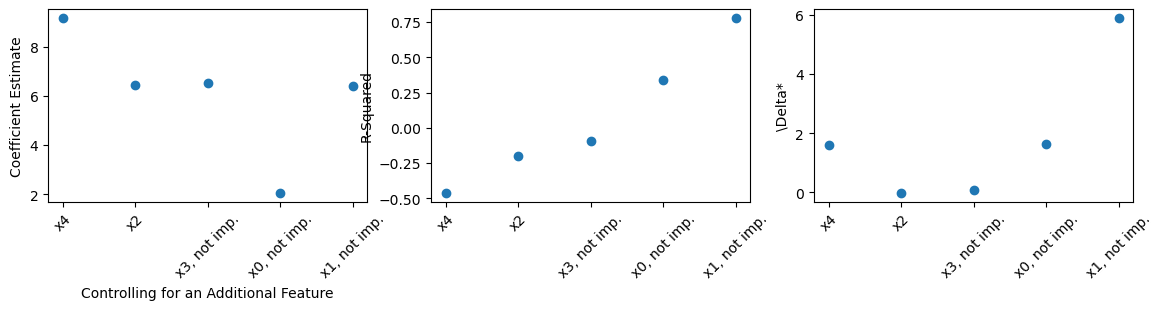

<Figure size 640x480 with 0 Axes>

In [24]:
fig,ax = plt.subplots(ncols=3,nrows=1,figsize=(14,2.5), sharex=True)
x_index = np.arange(len(outcome_feature_list))
ax[0].scatter(x_index, iterative_ml_coeff)
ax[1].scatter(x_index, iterative_ml_rsquared)
ax[2].scatter(x_index, iterative_delta_ml)
ax[0].set_xlabel('Controlling for an Additional Feature')
ax[0].set_ylabel('Coefficient Estimate')
ax[1].set_ylabel('R-Squared')
ax[2].set_ylabel('\Delta*')
ax[0].set_xticks(x_index,[outcome_feature_list[e]+', not imp.'*(e>=allK-notimportantK ) for e in range(len(outcome_feature_list))],
                rotation=45)
ax[1].set_xticks(x_index,[outcome_feature_list[e]+', not imp.'*(e>=allK-notimportantK ) for e in range(len(outcome_feature_list))],
                rotation=45)
ax[2].set_xticks(x_index,[outcome_feature_list[e]+', not imp.'*(e>=allK-notimportantK ) for e in range(len(outcome_feature_list))],
                rotation=45)
plt.show()
plt.tight_layout()
